# Machine Learning Project

# I. Introduction

Sequence classification is a type of predictive problem where we try to predict the category of a sequence of inputs over space or time. It is a hard task because the inputs can vary in length, the set of words (vocabulary) can be vary large and the model may want to understand the long-term context of a sequence.

## Description of the dataset

We will demonstrate sequence learning through a twitter sentiment analysis classification problem. Each tweet are short messages of varied length of words and the task is to build a classifier that can correctly predict the sentiment of each tweet.
Our dataset contains more than 1.2 million tweets, equally split in positive and negative messages. 

## Approach

We will approach this classification task by first getting an overlook of the dataset and the kind of messages we have at hand. Then we will apply some NLP techniques to transform our data into numerical objects (embedding) which we will feed into various Machine Learning Models. From Logistic Regressions to Deep Learning models, we will compare them and create a benchmark of various Supervised models for this classification task.

## Import

### Libraries and modules

In [2]:
# Base tools
import numpy as np
from numpy import array, asarray, zeros
import pandas as pd
from pprint import pprint
from time import time
import logging
#from ipynb.fs.full.Functions import *  # Import all functions from the Functions notebook
from Functions import ratio_positive, ratio_positive_all

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re, string

### Dataset

In [3]:
emote = pd.read_csv("data/MLUnige2021_train.csv",index_col=0)

# II. Exploratory Data Analysis & Feature Engineering

### First look at the data

Now that we've imported our training dataset, let's take a first look into it.

In [38]:
# Dataset shape
print("Dataset shape:", emote.shape)

# Dataset head
emote.head()

Dataset shape: (1280000, 6)


emotion    tweet_id                          date lyx_query         user  \
Id                                                                             
0         1  2063391019  Sun Jun 07 02:28:13 PDT 2009  NO_QUERY   BerryGurus   
1         0  2000525676  Mon Jun 01 22:18:53 PDT 2009  NO_QUERY  peterlanoie   
2         0  2218180611  Wed Jun 17 22:01:38 PDT 2009  NO_QUERY  will_tooker   
3         1  2190269101  Tue Jun 16 02:14:47 PDT 2009  NO_QUERY   sammutimer   
4         0  2069249490  Sun Jun 07 15:31:58 PDT 2009  NO_QUERY   ohaijustin   

                                                 text  
Id                                                     
0   @BreeMe more time to play with you BlackBerry ...  
1   Failed attempt at booting to a flash drive. Th...  
2   @msproductions Well ain't that the truth. Wher...  
3   @Meaghery cheers Craig - that was really sweet...  
4   I was reading the tweets that got send to me w...

This dataset contains not only the tweets and its corresponding emotions, but also the username of the sender, the date at which the tweet was sent and a last column which indicates if a specific query was used in processing the data. 

In [39]:
# Dataset info
emote.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280000 entries, 0 to 1279999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   emotion    1280000 non-null  int64 
 1   tweet_id   1280000 non-null  int64 
 2   date       1280000 non-null  object
 3   lyx_query  1280000 non-null  object
 4   user       1280000 non-null  object
 5   text       1280000 non-null  object
dtypes: int64(2), object(4)
memory usage: 68.4+ MB


###### Missing values

In [40]:
# Check missing emotions
print("Missing values in our data :", emote.isna().sum().sum())

# Check Query column
found = emote['lyx_query'].str.contains('NO_QUERY')
print("Instances of NO_QUERY in column 'lyx_query':", found.count())

Missing values in our data : 0
Instances of NO_QUERY in column 'lyx_query': 1280000


Our dataset doesn't contain any missing values. Moreover, we observe that the column 'lyx_query' is full of the same statement 'NO_QUERY'. Thus, this variable is of no use in the predictive aim of our model since it doesn't make any discrimination between any tweet.

###### Duplicates

In [41]:
# Unique tweets
print("Number of unique tweet id :", emote["tweet_id"].nunique())

# Number of duplicates
print('Number of duplicated tweets: ', emote["tweet_id"].duplicated().sum()) # Sums to 128000 with other unique ones, so no more than 1 copy per duplicated tweet

# Check duplicates
display(emote[emote["tweet_id"].duplicated()].head(3))

# Check copy of duplicated tweets
display(emote[emote['tweet_id'] == 2178343280])

Number of unique tweet id : 1278931
Number of duplicated tweets:  1069


emotion    tweet_id                          date lyx_query  \
Id                                                                   
18483        0  2178343280  Mon Jun 15 07:33:43 PDT 2009  NO_QUERY   
40648        0  1990826216  Mon Jun 01 05:49:56 PDT 2009  NO_QUERY   
52008        1  2182706647  Mon Jun 15 13:31:41 PDT 2009  NO_QUERY   

               user                                               text  
Id                                                                      
18483      Dimonios  @ontd30stm  http://bit.ly/2yn5l7 Delicious  th...  
40648  SophieAndrea  @fordiddy tell me about it.  because it's my l...  
52008    conorjryan  knowing me I'll tweet as soon as I get one and...

emotion    tweet_id                          date lyx_query      user  \
Id                                                                             
13405        1  2178343280  Mon Jun 15 07:33:43 PDT 2009  NO_QUERY  Dimonios   
18483        0  2178343280  Mon Jun 15 07:33:43 PDT 2009  NO_QUERY  Dimonios   

                                                    text  
Id                                                        
13405  @ontd30stm  http://bit.ly/2yn5l7 Delicious  th...  
18483  @ontd30stm  http://bit.ly/2yn5l7 Delicious  th...

In [42]:
# Remove duplicates
emote = emote.drop_duplicates(subset='tweet_id')
print('New dataframe size: ', emote.shape)

New dataframe size:  (1278931, 6)


###### Users 

In [43]:
# Check unique users
print("Number of unique users :", emote["user"].nunique())

Number of unique users : 574114


In [44]:
# Users message distribution
print("Users and tweets count :")
print(emote["user"].value_counts()) # some of them commented a lot
print()
tweeted_once = sum(emote["user"].value_counts() == 1)
print("Number of users that tweeted only once: {} ({}%)".format(tweeted_once,round(tweeted_once/len(emote)*100,2)))

Users and tweets count :
lost_dog         446
webwoke          292
tweetpet         239
VioletsCRUK      234
mcraddictal      226
                ... 
mfitzii            1
julianchansax      1
Antmfan227         1
jaymieg            1
JonesTheFilm       1
Name: user, Length: 574114, dtype: int64

Number of users that tweeted only once: 365638 (28.59%)


About a quarter of the twitter users in our training dataset only tweeted once during that period, while some of them went as far as tweeting several hundred times.

###### Emotions

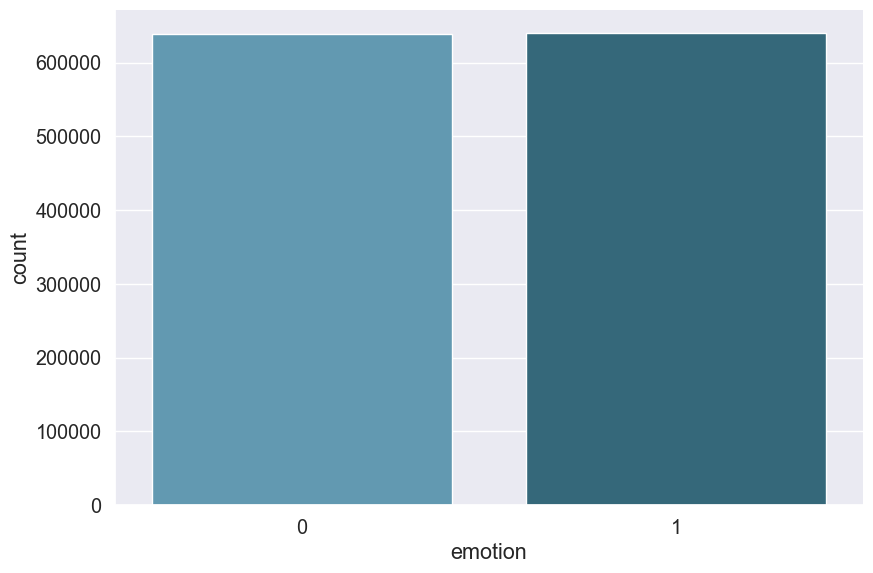

Number of positive tweets : 639564
Number of negative tweets : 639367


In [45]:
# Plot positive & negative tweets
sns.catplot(x="emotion", data=emote, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

# Sum of positive & negative tweets
print("Number of positive tweets :", sum(emote["emotion"] == 1))
print("Number of negative tweets :", sum(emote["emotion"] == 0))

We are training on a pretty balanced dataset with as much positive and negative tweets. This will let us perform train/test split without the need of stratifying.

### 5 Most talkative users data

#### lost_dog

In [46]:
# User who tweeted the most
user = 'lost_dog'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 0/446 (0.0%)


emotion    tweet_id                          date lyx_query      user  \
Id                                                                             
8229         0  2209419659  Wed Jun 17 10:22:06 PDT 2009  NO_QUERY  lost_dog   
9527         0  2328965183  Thu Jun 25 10:11:34 PDT 2009  NO_QUERY  lost_dog   
10645        0  2072079020  Sun Jun 07 20:21:54 PDT 2009  NO_QUERY  lost_dog   
14863        0  2214285766  Wed Jun 17 16:31:38 PDT 2009  NO_QUERY  lost_dog   
16723        0  1696136174  Mon May 04 07:41:03 PDT 2009  NO_QUERY  lost_dog   

                                                    text  
Id                                                        
8229   @JamieDrokan I am lost. Please help me find a ...  
9527   @W_Hancock I am lost. Please help me find a go...  
10645  @miznatch I am lost. Please help me find a goo...  
14863  @kgustafson I am lost. Please help me find a g...  
16723  @kneeon I am lost. Please help me find a good ...

lost_dog is definitely a spam bot, all the 446 messages seem to be identical: "@random_user I am lost. Please help me find a good home."

#### webwoke

In [47]:
user = 'webwoke'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 68/292 (23.29%)


emotion    tweet_id                          date lyx_query     user  \
Id                                                                            
19553        0  2067697514  Sun Jun 07 12:48:05 PDT 2009  NO_QUERY  webwoke   
24144        0  2072285184  Sun Jun 07 20:44:08 PDT 2009  NO_QUERY  webwoke   
25988        0  2055206809  Sat Jun 06 08:54:04 PDT 2009  NO_QUERY  webwoke   
28219        1  2053451192  Sat Jun 06 04:36:04 PDT 2009  NO_QUERY  webwoke   
28597        1  2066463084  Sun Jun 07 10:34:05 PDT 2009  NO_QUERY  webwoke   

                                             text  
Id                                                 
19553   come on... drop by 1  44. blogtoplist.com  
24144      owww god, drop by 18  57. blogspot.com  
25988             F**K! drop by 1  97. zimbio.com  
28219    uhuiii... move up by 1  69. hubpages.com  
28597  GoGoGo... move up by 1  13. slideshare.net

Looks like webwoke is a spam bot making a request to visit some random website.

#### tweetpet

In [48]:
user = 'tweetpet'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 0/239 (0.0%)


emotion    tweet_id                          date lyx_query      user  \
Id                                                                             
11130        0  1676425868  Fri May 01 22:00:38 PDT 2009  NO_QUERY  tweetpet   
13494        0  1573611322  Tue Apr 21 02:00:03 PDT 2009  NO_QUERY  tweetpet   
17443        0  1676426980  Fri May 01 22:00:49 PDT 2009  NO_QUERY  tweetpet   
23973        0  1677423044  Sat May 02 02:00:12 PDT 2009  NO_QUERY  tweetpet   
33463        0  1676426375  Fri May 01 22:00:43 PDT 2009  NO_QUERY  tweetpet   

                             text  
Id                                 
11130  @CeladonNewTown  Clean Me!  
13494     @chromachris  Clean Me!  
17443      @Kamryn6179  Clean Me!  
23973   @greenbizdaily  Clean Me!  
33463    @ANALOVESTITO  Clean Me!

Tweetpet messages also all seem to be identical, it is probably a bot sending notifications to specific users.

#### VioletsCRUK

In [49]:
user = 'VioletsCRUK'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 180/234 (76.92%)


emotion    tweet_id                          date lyx_query  \
Id                                                                   
8319         0  2057611341  Sat Jun 06 13:19:41 PDT 2009  NO_QUERY   
9102         1  1573700635  Tue Apr 21 02:26:06 PDT 2009  NO_QUERY   
16570        1  1980137710  Sun May 31 05:49:01 PDT 2009  NO_QUERY   
37711        1  1881181047  Fri May 22 03:52:11 PDT 2009  NO_QUERY   
37909        0  2067636547  Sun Jun 07 12:41:40 PDT 2009  NO_QUERY   

              user                                               text  
Id                                                                     
8319   VioletsCRUK  @marginatasnaily lol i was chucked of 4 times ...  
9102   VioletsCRUK  @highdigi Nothing worse! Rain has just started...  
16570  VioletsCRUK  Will catch up with yas later..goin for a solid...  
37711  VioletsCRUK  @Glasgowlassy lol oh that's a big buffet of ha...  
37909  VioletsCRUK  @jimkerr09 That was a really lovely tribute to...

VioletsCRUK seems to be our most active user that is not a bot, with a high ratio of positive and varied messages.

#### mcraddictal

In [50]:
user = 'mcraddictal'
print('Ratio of positive messages: {}/{} ({}%)'.format(*ratio_positive_all(user, emote)))
emote[emote["user"] == user].head()

Ratio of positive messages: 54/226 (23.89%)


emotion    tweet_id                          date lyx_query  \
Id                                                                   
2337         0  2059074446  Sat Jun 06 16:11:42 PDT 2009  NO_QUERY   
2815         0  1968268387  Fri May 29 21:05:43 PDT 2009  NO_QUERY   
7448         0  2052420061  Sat Jun 06 00:40:11 PDT 2009  NO_QUERY   
10092        0  2061250826  Sat Jun 06 20:29:01 PDT 2009  NO_QUERY   
13533        0  1981070459  Sun May 31 08:20:52 PDT 2009  NO_QUERY   

              user                                               text  
Id                                                                     
2337   mcraddictal  @MyCheMicALmuse pleaseeee tell me? -bites nail...  
2815   mcraddictal                                        @MCRmuffin   
7448   mcraddictal     @chemicalzombie dont make me say it  you know.  
10092  mcraddictal  @NoRaptors noooooo begging  i hate that. I'm s...  
13533  mcraddictal  @Boy_Kill_Boy  so was haunting in ct. That mov...

mcRaddictal seems to also be a common user with varied text messages, this time mostly negative tweets.

Out of the 5 users that tweeted the most, it seems like 3 of them are some kind of bot or spam bot. The 4th and 5th ones seem to be random users from which we got a lot tweets in the database.
All these users show pattern in the tweets the sent, they all have either a high positive or high negative emotion count. 'Lost_dog' and 'tweetpet' both sent only negative tweets out of hundreds of them. 'webwoke' and 'mcraddictal' also sent largely negative tweets while 'VioletsCRUK' sent mostly positive tweets. We'll take this information into account when building our classifier.

###### Date

In [51]:
print('Earliest tweet: ', min(emote['date']))
print('Latest tweet: ', max(emote['date']))


Earliest tweet:  Fri Apr 17 20:30:31 PDT 2009
Latest tweet:  Wed May 27 07:27:38 PDT 2009


In [52]:
################################# Further work needed #################################################
#from datetime import * # !!! Makes time() function fail in the gridsearch algorithm

dt = min(emote['date'])
print(min(emote['date']))
date_format = '%a %b %d %I:%M:%S %Z %Y'
#date_format = '%a %b %d %X %Z %Y'
#date_format = "%c"

#datetime.strptime(dt, date_format)
# Issue: strptime %z doesn't take PDT as a timezone, only GMT and UTC, changing all the dates takes a bit 
# of time, altough could improve model, will check later

# SHOULD HAVE WORKED LIKE THIS
date_str = '02/28/2023 02:30 PM'
date_format = '%m/%d/%Y %I:%M %p'
#datetime.strptime(date_str, date_format)
# from time import time
################################# Further work needed #################################################

Fri Apr 17 20:30:31 PDT 2009


###### Tweet length

Shortest tweet length: 2
Largest tweet length: 110


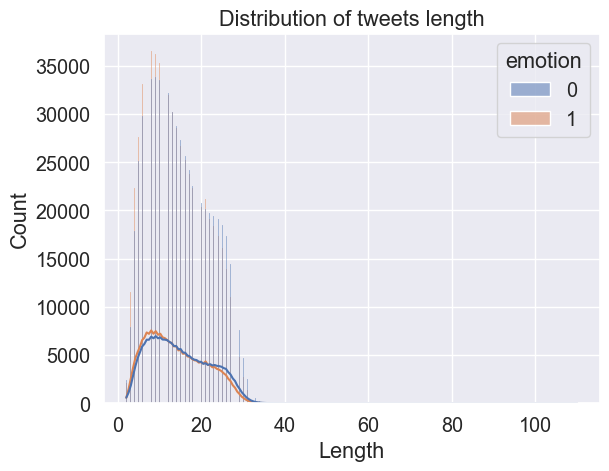

In [53]:
# Distribution of tweets length
emote['length'] = emote['text'].apply(lambda x: len(x.split(' ')))
print('Shortest tweet length:', min(emote['length']))
print('Largest tweet length:', max(emote['length']))
sns.histplot(data=emote, x='length', hue='emotion', kde=True)
plt.xlabel('Length');
plt.title('Distribution of tweets length');

### Symbols
Make text lowercase, remove text in square brackets, remove links, remove punctuation, and remove words containing numbers:

In [54]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [55]:
# Create a clean text column
emote['text_clean'] = emote['text'].apply(clean_text)
emote.head(3)

emotion    tweet_id                          date lyx_query         user  \
Id                                                                             
0         1  2063391019  Sun Jun 07 02:28:13 PDT 2009  NO_QUERY   BerryGurus   
1         0  2000525676  Mon Jun 01 22:18:53 PDT 2009  NO_QUERY  peterlanoie   
2         0  2218180611  Wed Jun 17 22:01:38 PDT 2009  NO_QUERY  will_tooker   

                                                 text  length  \
Id                                                              
0   @BreeMe more time to play with you BlackBerry ...      10   
1   Failed attempt at booting to a flash drive. Th...      27   
2   @msproductions Well ain't that the truth. Wher...      23   

                                           text_clean  
Id                                                     
0   breeme more time to play with you blackberry t...  
1   failed attempt at booting to a flash drive the...  
2   msproductions well aint that the truth whered ...

### Stopwords
Remove stopwords (a list of not useful english words like 'the', 'at', etc.). It allows us to reduce dimension of the data when tokenizing.

In [56]:
# Define the stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

# Remove stopwords
emote['text_clean'] = emote['text_clean'].apply(remove_stopwords)
emote.head()

emotion    tweet_id                          date lyx_query         user  \
Id                                                                             
0         1  2063391019  Sun Jun 07 02:28:13 PDT 2009  NO_QUERY   BerryGurus   
1         0  2000525676  Mon Jun 01 22:18:53 PDT 2009  NO_QUERY  peterlanoie   
2         0  2218180611  Wed Jun 17 22:01:38 PDT 2009  NO_QUERY  will_tooker   
3         1  2190269101  Tue Jun 16 02:14:47 PDT 2009  NO_QUERY   sammutimer   
4         0  2069249490  Sun Jun 07 15:31:58 PDT 2009  NO_QUERY   ohaijustin   

                                                 text  length  \
Id                                                              
0   @BreeMe more time to play with you BlackBerry ...      10   
1   Failed attempt at booting to a flash drive. Th...      27   
2   @msproductions Well ain't that the truth. Wher...      23   
3   @Meaghery cheers Craig - that was really sweet...      15   
4   I was reading the tweets that got send to me w...      29   

                                           text_clean  
Id                                                     
0                        breeme time play blackberry   
1   failed attempt booting flash drive failed atte...  
2   msproductions well aint truth whered damn auto...  
3   meaghery cheers craig  really sweet reply pumped   
4   reading tweets got send lying phone face dropp...

### Stemming/ Lematization

Stemming cuts off prefixes and suffixes (ex: laziness -> lazi). Lemma converts words (ex: writing, writes) into its radical (ex: write).

In [57]:
# Initiate stemmer
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [58]:
# Apply stemming
emote['text_clean'] = emote['text_clean'].apply(stemm_text)
emote.head()

emotion    tweet_id                          date lyx_query         user  \
Id                                                                             
0         1  2063391019  Sun Jun 07 02:28:13 PDT 2009  NO_QUERY   BerryGurus   
1         0  2000525676  Mon Jun 01 22:18:53 PDT 2009  NO_QUERY  peterlanoie   
2         0  2218180611  Wed Jun 17 22:01:38 PDT 2009  NO_QUERY  will_tooker   
3         1  2190269101  Tue Jun 16 02:14:47 PDT 2009  NO_QUERY   sammutimer   
4         0  2069249490  Sun Jun 07 15:31:58 PDT 2009  NO_QUERY   ohaijustin   

                                                 text  length  \
Id                                                              
0   @BreeMe more time to play with you BlackBerry ...      10   
1   Failed attempt at booting to a flash drive. Th...      27   
2   @msproductions Well ain't that the truth. Wher...      23   
3   @Meaghery cheers Craig - that was really sweet...      15   
4   I was reading the tweets that got send to me w...      29   

                                           text_clean  
Id                                                     
0                         breem time play blackberri   
1   fail attempt boot flash drive fail attempt swi...  
2   msproduct well aint truth where damn autolock ...  
3      meagheri cheer craig  realli sweet repli pump   
4   read tweet got send lie phone face drop ampit ...

### Wordclouds

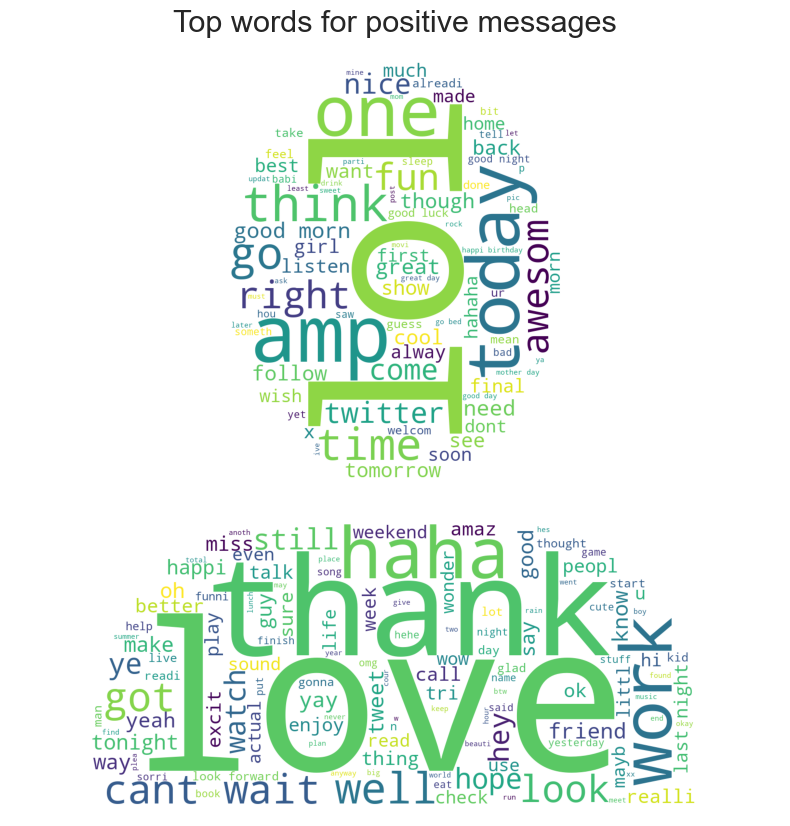

In [59]:
# Wordcloud positive words
twitter_mask = np.array(Image.open('./img/user.jpeg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in emote.loc[emote['emotion'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for positive messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

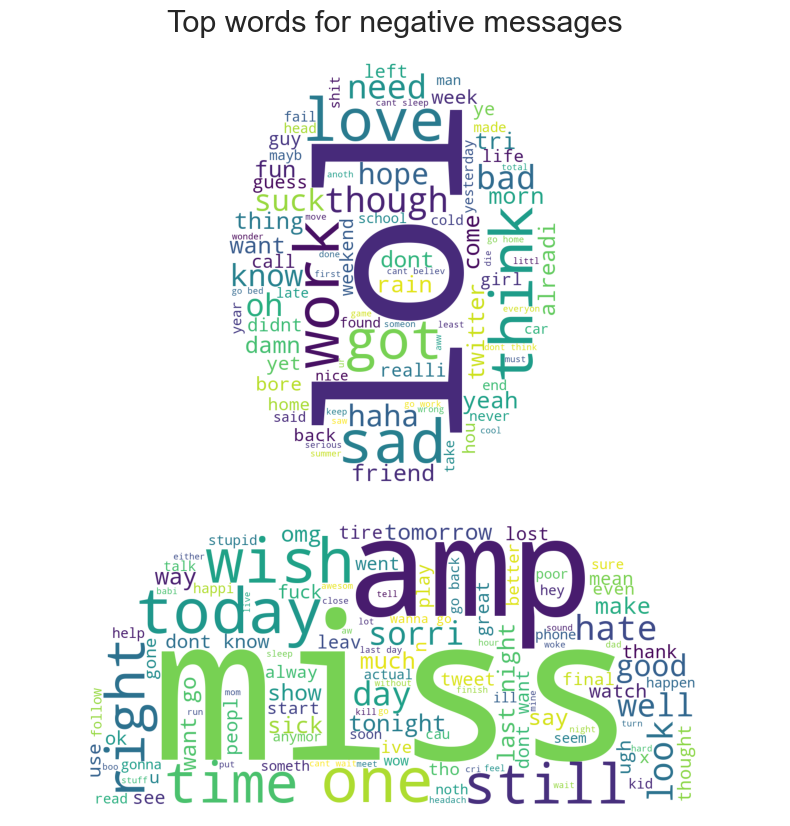

In [60]:
# Wordcloud negative words
twitter_mask = np.array(Image.open('./img/user.jpeg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in emote.loc[emote['emotion'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for negative messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Now that we have taken a good first look at our data. It is time to build some models. Since we are trying to predict a binary outcome, that is the sentiment of a given tweet, we will proceed with classification algorithms. <br>
First, we need to transform our text data into a numerical structure that can be processed by the algorithms. We do so by using NLP techniques that transform text data into tokens using a vectorizer. These tokens can then be weighted depending on words occurrences and possible importance through a Term-Frequency & Inverse-Document-Frequency (TF-IDF) operation.
We can then apply various classification algorithms on our transformed text data to make prediction on the sentiment of a tweet. <br>
Looking at the 5 most talkative users and their messages polarity, it seems to be a good idea to add usernames as part of the independent variables. Thus our features consist of transformed text with associated usernames.

In [6]:
# Keep only user, text and emotion class
emote = emote[['emotion', 'user', 'text']] 
#emote = emote[['emotion', 'user', 'text', 'text_clean']] # model from the class project
#emote = emote[['emotion', 'user', 'text', 'date']] # should have done this

emote_50 = emote[:50000]   #  50.000 first obs
emote_100 = emote[:100000] # 100.000 first obs
emote_320 = emote[:320000] #  about 1/4 of obs
emote_640 = emote[:640000] #  about 1/2 of obs

### Feature Engineering : TF-IDF and word embeddings

Machine Learning models don't process raw text data. We have to first translate the messages as sequences of numerical tokens. The words are encoded as vectors in a high dimensional space where the similarity in words meaning translates into closeness in the vectorial space.

##### The Vectorization and TF-IDF method

We will extract the numerical features of our text content using a first tool that will vectorize our corpus then a second one that will take into account the frequency of appearance of our words tokens. 

First, we make use of CountVectorizer. This method tokenizes strings of words by transforming them into tokens (using white spaces as token separators) and counts the occurrences of words in our text dataset.

In [62]:
# Data split
X_train, X_test, y_train, y_test = train_test_split((emote_50.text + emote_50.user), emote_50.emotion, test_size=0.1, random_state=37)
print("First 5 entries of training dataset :", X_train.head())

First 5 entries of training dataset : Id
48733    says good morning!  http://plurk.com/p/yyfu1or...
10709    @winebybrad No we had right amount of wine. No...
34219              But hey, free money is free money c0rsa
30883                   Free ice cream and I said no mrl14
36640    @andrewbravener Happy Birthday!  What's better...
dtype: object


In the following section, we will insert these vectorizer and tfidf transformer into the Machine Learning pipeline. It will help us hypertune independently each model.

### CountVectorizer

CountVectorizer is a feature extraction technique in natural language processing (NLP) and text mining. It is a part of the scikit-learn library in Python and is used to convert a collection of text documents to a matrix of token counts. In simpler terms, it transforms a set of text documents into a matrix, where each row represents a document, each column represents a unique word in the corpus, and the entries are the counts of each word in the respective documents.

Here's a basic overview of how CountVectorizer works:

**Tokenization**: It first tokenizes the text, which means it breaks down the text into individual words or terms. This process involves removing punctuation and splitting the text into words.

**Counting**: It then counts the occurrences of each word in the text. The result is a sparse matrix where each row corresponds to a document, each column corresponds to a unique word, and the entries represent the frequency of each word in the respective documents.

**CountVectorizer** is a fundamental step in many text-based machine learning applications, providing a way to represent textual data in a format that machine learning algorithms can understand and process. It's important to note that the resulting matrix can be quite large and sparse, especially when dealing with a large vocabulary or a large number of documents.

In [63]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
X_cv_train = count_vectorizer.fit_transform(X_train)
X_cv_test = count_vectorizer.transform(X_test)

### TF-IDF

**TF-IDF** stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus). TF-IDF is commonly used in information retrieval and text mining as a way to evaluate the importance of a term within a document or a set of documents.

Here's a breakdown of the components:

**Term Frequency (TF)**: This component measures how often a term appears in a document. It is calculated as the ratio of the number of times a term occurs in a document to the total number of terms in that document. The idea is that more frequent terms are likely to be more important within the document.

**TF(t,d)** = Number of times term t appears in document d / Total number of terms in document d

**Inverse Document Frequency (IDF)**: This component measures how important a term is across a collection of documents. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. Terms that appear in fewer documents are assigned a higher IDF weight, as they are considered more informative.

**IDF(t,D)** = log(Total number of documents in the corpus N / Number of documents containing term t+1)

The addition of 1 in the denominator is known as "smoothing" and helps avoid division by zero when a term is not present in any document.

**TF-IDF Score**: The TF-IDF score for a term in a document is the product of its Term Frequency and Inverse Document Frequency.

**TF-IDF(t,d,D)** = TF(t,d) Ã— IDF(t,D)

The TF-IDF score emphasizes terms that are frequent within a specific document but relatively rare across the entire document collection. This helps in identifying terms that are important and distinctive to a particular document.

TF-IDF is widely used in tasks such as text mining, information retrieval, and document classification. It helps in transforming unstructured text data into a numerical format that can be used for machine learning algorithms.

Now we reweight the words counts through TF-IDF so that they can be used by classifier methods.

In [64]:
tfidftransformer = TfidfTransformer()
X_tf_train = tfidftransformer.fit_transform(X_cv_train)
X_tf_test = tfidftransformer.transform(X_cv_test)

These steps can also be grouped as one unique one through:

In [65]:
tfidf = TfidfVectorizer() # same as CountVectorizer() + TfidfTransformer() combined
X_tf_train = tfidf.fit_transform(X_train)
X_tf_test = tfidf.transform(X_test)

# Appendix

### Word embeddings

In [32]:
from gensim.models import Word2Vec  # https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import FastText  # https://radimrehurek.com/gensim/models/fasttext.html
import gensim.downloader as api


def vectorize_tweet(tweet, model):
    # Get vector representation for each word and average them to get the tweet vector
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    if not vectors:
        return None
    return sum(vectors) / len(vectors)

In [34]:
# Keep only user, text and emotion class
emote = emote[['emotion', 'user', 'text']] 
#emote_ = emote[['emotion', 'user', 'text', 'text_clean']] # model from the class project
#emote = emote[['emotion', 'user', 'text', 'date']] # should have done this

emote_50 = emote[:50000]   #  50.000 first obs
emote_100 = emote[:100000] # 100.000 first obs
emote_320 = emote[:320000] #  about 1/4 of obs
emote_640 = emote[:640000] #  about 1/2 of obs

NameError: name 'emote_' is not defined

In [ ]:
import gensim.downloader as api

glove_model = api.load('glove-twitter-25')
sample_glove_embedding = glove_model['computer']

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

v2w_model = v2w_model = api.load('word2vec-google-news-300')
sample_word2vec_embedding = v2w_model['computer']

In [ ]:
# Without text_clean

data = emote_50_
w2v_model = Word2Vec(sentences=(emote_50.text + emote_50.user),
                     vector_size=100,
                     window=5,
                     min_count=0,
                     workers=4)

# Vectorize all tweets
X_w2v = [
    vectorize_tweet(tweet, w2v_model)
    for tweet in (emote_50.text + emote_50.user)
]

In [ ]:
# Without text preprocess

X_train, X_test, y_train, y_test = train_test_split(X_w2v,
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

logreg = LogisticRegression(C=0.9, solver='lbfgs', penalty='l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print('Accuracy: ', logreg.score(X_test, y_test))

In [ ]:
# With text_clean

data = emote_50_
w2v_model = Word2Vec(sentences=(data.text_clean + data.user),
                     vector_size=100,
                     window=5,
                     min_count=1,
                     workers=4)

# Vectorize all tweets
X_w2v = [
    vectorize_tweet(tweet, w2v_model)
    for tweet in (data.text_clean + data.user)
]

In [ ]:
# Without text preprocess

X_train, X_test, y_train, y_test = train_test_split(X_w2v,
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

logreg = LogisticRegression(C=0.9, solver='lbfgs', penalty='l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print('Accuracy: ', logreg.score(X_test, y_test))

In [ ]:
data = emote_50_
ft_model = FastText(sentences=(data.text + data.user), min_count=0)

# Vectorize all tweets
X_ft = [vectorize_tweet(tweet, ft_model) for tweet in (data.text + data.user)]

In [ ]:
# Without text preprocess

X_train, X_test, y_train, y_test = train_test_split(X_ft,
                                                    data.emotion,
                                                    test_size=0.2,
                                                    random_state=37)

logreg = LogisticRegression(C=0.9, solver='lbfgs', penalty='l2')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    mat,
    fmt='d',
    cbar=False,
    annot=True,
    #square=True,
    cmap=plt.cm.Blues,
    xticklabels=('Negative', 'Positive'),
    yticklabels=('Negative', 'Positive'))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
print('Accuracy: ', logreg.score(X_test, y_test))

while TF-IDF focuses on the frequency and uniqueness of words in a document and represents text as sparse vectors, word embeddings focus on capturing semantic relationships between words in a continuous vector space. TF-IDF is simpler and interpretable, but it may not capture complex semantic nuances. On the other hand, word embeddings provide dense and context-aware representations, allowing models to understand the meaning and context of words in a more sophisticated manner. 

### Preprocessing Effectiveness

One way of getting increasing the performance of a model is to apply preprocessing methods on the text. Let's see if it makes a difference here. <br>
Here's a first logistic model fit on 50 000 observations, with preprocessing :

In [68]:
# Define the train and test sets (50 000 observations)
X_train, X_test, y_train, y_test = train_test_split((emote_50.text_clean + emote_50.user), emote_50.emotion, test_size=0.1, random_state=37)

# Define the parameters to tune
parameters_log = {
    # 'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'model__C': (0.5, 0.75, 1.0),
    'model__penalty': ('l2','l1'),
}

# Perform the grid search
GridSearch_(X_train, y_train, parameters = parameters_log, model = LogisticRegression(solver='liblinear'))
# Acc:0.756 without symbols/stopwords; Acc:0.756 without symbols/stopwords/stemming

Performing grid search...
pipeline: ['vect', 'tfidf', 'model']
parameters:
{'model__C': (0.5, 0.75, 1.0),
 'model__penalty': ('l2', 'l1'),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
done in 55.005s

Best score: 0.756
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	vect__ngram_range: (1, 2)


We achieved a prediction score of 76% using logistic regression on 50 000 observations. Let's now compare this score with the one using the unprocessed data :

In [54]:
# Define the train and test sets (50 000 observations)
X_train, X_test, y_train, y_test = train_test_split((emote_50.text + emote_50.user), emote_50.emotion, test_size=0.1, random_state=37)

# Define the parameters to tune
parameters_log = {
    # 'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'model__C': (0.5, 0.75, 1.0),
    'model__penalty': ('l2','l1'),
}

# Perform the grid search
GridSearch_(X_train, y_train, parameters = parameters_log, model = LogisticRegression(solver='liblinear'))

Performing grid search...
pipeline: ['vect', 'tfidf', 'model']
parameters:
{'model__C': (0.5, 0.75, 1.0),
 'model__penalty': ('l2', 'l1'),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
done in 91.751s

Best score: 0.773
Best parameters set:
	model__C: 1.0
	model__penalty: 'l2'
	vect__ngram_range: (1, 2)


We achieved a prediction score of 77.7% with 50 000 observations using logistic regression on unprocessed data. We observe that the preprocess is actually hurting our prediction accuracy.

**In this case, we fitted the same models once without any kind of preprocess and a second time using various preprocess methods. Selecting each of these methods separately (not shown here) guided us in the same direction. We found no preprocess techniques worth adding in the aim of better prediction accuracy for this dataset.**